In [1]:
# Import required modules
from copy import copy

import numpy as np
import time

from lcode2dPy.plasma3d.initialization import init_plasma
from lcode2dPy.plasma3d.solver import Plane2d3vPlasmaSolver

from lcode2dPy.config.default_config import default_config

In [2]:
# Create a config
config = copy(default_config)

config.update({
    'geometry': '3d',
    'processing-unit-type': 'npu',
    'window-width-step-size': 0.05,
    'window-width': 20,

    'window-length': 5,
    'xi-step': 0.05,

    'time-limit': 1e-10,
    'time-step': 1e-10,

    'plasma-particles-per-cell': 1,
    'noise-reductor-amplitude': 1
})

# Make ready a plasma solver
solver = Plane2d3vPlasmaSolver(config)

In [3]:
# Create a transversal grid and a beam charge distribution
grid_steps     = config.getint('window-width-steps')
grid_step_size = config.getfloat('window-width-step-size')

grid = ((np.arange(grid_steps) - grid_steps // 2)
        * grid_step_size)
xs, ys = grid[:, None], grid[None, :]

def rho_b(xi):
    COMPRESS, BOOST, SIGMA, SHIFT = 1, 1, 1, 0
    if xi < -2 * np.sqrt(2 * np.pi) / COMPRESS or xi > 0:
        return 0.
        # return np.zeros_like(xs)
    r = np.sqrt(xs**2 + (ys - SHIFT)**2)
    return (.05 * BOOST * np.exp(-.5 * (r / SIGMA)**2) *
            (1 - np.cos(xi * COMPRESS * np.sqrt(np.pi / 2))))

In [5]:
# Create the first plasma slice
fields, particles, currents, const_arrays = init_plasma(config)

# Simulation loop:
start_time = time.time()
xi_step_size = config.getfloat('xi-step')
xi_steps = int(config.getfloat('window-length') / xi_step_size)
ez = []
phi = []
xi_arr = []

ro_beam_prev = 0

gpu_index = 0

with np.cuda.Device(gpu_index):
    for xi_i in range(xi_steps + 1):
        xi = - xi_i * xi_step_size
        
        ro_beam = rho_b(xi)
        ro_beam_prev = rho_b(xi + xi_step_size)

        particles, fields, currents = solver.step_dxi(
            particles, fields, currents, const_arrays, ro_beam, ro_beam_prev
        )

        ez.append(fields.Ez[grid_steps // 2, grid_steps // 2])
        phi.append(fields.Phi[grid_steps // 2, grid_steps // 2])
        xi_arr.append(xi)
        if xi_i % 1. == 0:
            print(f'xi={xi:+.4f} {ez[-1]:+.4e}')
            
        # if xi % 25. == 0:
        #     view_currents = GPUArraysView(currents)
        #     ro_diagnostics(xi, view_currents.ro)
        #     np.savez('log', xi=xi_arr, Ez_00=ez)
    
print("--- %s seconds ---" % (time.time() - start_time))

/home/ivan/.local/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/home/ivan/Desktop/work/lcodePy-test1-benchmarking/lcodePy/lcode2dPy/plasma3d_gpu/initialization.py:65: RuntimeWarning: divide by zero encountered in true_divide
  mul = 1 / (lambda_i + lambda_j)  # WARNING: zero division in mul[0, 0]!


xi=+0.0000 +3.2717e-20
xi=-0.0200 -7.2461e-08
xi=-0.0400 -4.3470e-07
xi=-0.0600 -1.3762e-06
xi=-0.0800 -3.1858e-06
xi=-0.1000 -6.1516e-06
xi=-0.1200 -1.0560e-05
xi=-0.1400 -1.6697e-05
xi=-0.1600 -2.4846e-05
xi=-0.1800 -3.5287e-05
xi=-0.2000 -4.8301e-05
xi=-0.2200 -6.4164e-05
xi=-0.2400 -8.3149e-05
xi=-0.2600 -1.0553e-04
xi=-0.2800 -1.3156e-04
xi=-0.3000 -1.6152e-04
xi=-0.3200 -1.9566e-04
xi=-0.3400 -2.3424e-04
xi=-0.3600 -2.7750e-04
xi=-0.3800 -3.2570e-04
xi=-0.4000 -3.7906e-04
xi=-0.4200 -4.3783e-04
xi=-0.4400 -5.0224e-04
xi=-0.4600 -5.7250e-04
xi=-0.4800 -6.4884e-04
xi=-0.5000 -7.3146e-04
xi=-0.5200 -8.2058e-04
xi=-0.5400 -9.1638e-04
xi=-0.5600 -1.0191e-03
xi=-0.5800 -1.1288e-03
xi=-0.6000 -1.2458e-03
xi=-0.6200 -1.3702e-03
xi=-0.6400 -1.5021e-03
xi=-0.6600 -1.6418e-03
xi=-0.6800 -1.7893e-03
xi=-0.7000 -1.9448e-03
xi=-0.7200 -2.1085e-03
xi=-0.7400 -2.2804e-03
xi=-0.7600 -2.4606e-03
xi=-0.7800 -2.6493e-03
xi=-0.8000 -2.8465e-03
xi=-0.8200 -3.0524e-03
xi=-0.8400 -3.2670e-03
xi=-0.8600 

In [6]:
np.savez_compressed(
    file='plasmastate_after_the_head',
    x_offt=particles.x_offt, y_offt=particles.y_offt,
    px=particles.px, py=particles.py, pz=particles.pz,
    Ex=fields.Ex, Ey=fields.Ey, Ez=fields.Ez,
    Bx=fields.Bx, By=fields.By, Bz=fields.Bz,
    Phi=fields.Phi, ro=currents.ro,
    jx=currents.jx, jy=currents.jy, jz=currents.jz
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def rho_b(xi, r):
    COMPRESS, BOOST, SIGMA, SHIFT = 1, 1, 1, 0
    if xi < -2 * np.sqrt(2 * np.pi) / COMPRESS or xi > 0:
        return 0.
        # return np.zeros_like(xs)
    return (.05 * BOOST * np.exp(-.5 * (r / SIGMA)**2) *
            (1 - np.cos(xi * COMPRESS * np.sqrt(np.pi / 2))))

rho_beam = [rho_b(xi, 0) for xi in np.linspace(-5, 0, 50)]

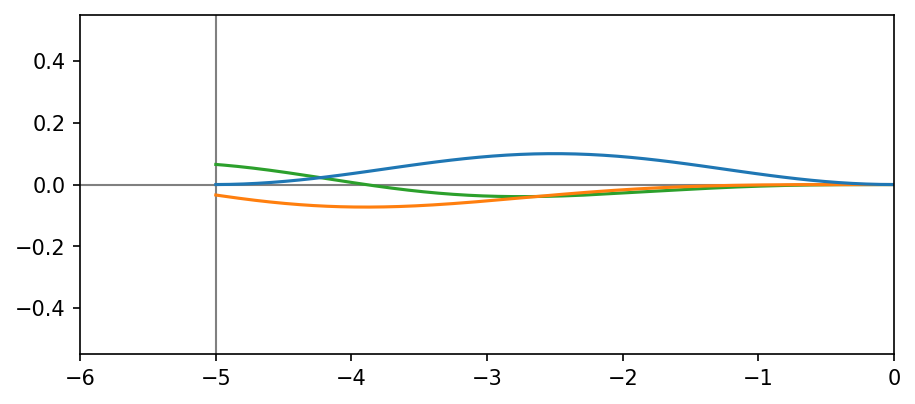

In [ ]:
plt.figure(figsize = (7, 3), dpi=150)
plt.ylim(-.55, .55)
plt.xlim(-6, 0)

plt.hlines(0, -6.1, 0, color='grey', lw=1)
plt.vlines(-5, -.55, .55, color='grey', lw=1)

plt.plot(xi_arr, ez,  color='tab:green')
plt.plot(xi_arr, phi, color='tab:orange')
plt.plot(np.linspace(-5, 0, 50), rho_beam,  color='tab:blue')

In [ ]:
# Should work correctly. Compare results with:
# xi         Ez_00
# xi=+0.0000 +0.0000e+00
# xi=+0.0200 -1.4490e-07
# xi=+0.0400 -7.2443e-07
# xi=+0.0600 -2.0278e-06
# xi=+0.0800 -4.3436e-06
# xi=+0.1000 -7.9592e-06
# xi=+0.1200 -1.3161e-05
# xi=+0.1400 -2.0233e-05
# xi=+0.1600 -2.9458e-05
# xi=+0.1800 -4.1116e-05
# xi=+0.2000 -5.5486e-05
# xi=+0.2200 -7.2842e-05
# xi=+0.2400 -9.3456e-05
# xi=+0.2600 -1.1760e-04
# xi=+0.2800 -1.4553e-04
# xi=+0.3000 -1.7751e-04
# xi=+0.3200 -2.1381e-04
# xi=+0.3400 -2.5467e-04
# xi=+0.3600 -3.0033e-04
# xi=+0.3800 -3.5105e-04
# xi=+0.4000 -4.0706e-04
# xi=+0.4200 -4.6859e-04
# xi=+0.4400 -5.3587e-04
# xi=+0.4600 -6.0912e-04
# xi=+0.4800 -6.8855e-04
# xi=+0.5000 -7.7437e-04